In [1]:
import gym
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random

from keras import backend as K
from keras.layers import Dense, Activation, Input, concatenate,Lambda,GaussianNoise
from keras.models import Model, load_model
from keras.optimizers import Adam
from IPython.display import clear_output

from warnings import filterwarnings
filterwarnings('ignore')


import seaborn as sns
sns.set_context("paper")
sns.set_style("darkgrid")

import torch as T
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

Using TensorFlow backend.


In [5]:
env=gym.make("Pendulum-v0")
env.reset()
state_dim = env.observation_space.shape
lower_bound_action,upper_bound_action=env.action_space.low,env.action_space.high
n_actions = lower_bound_action.shape[0]

In [6]:
class DDPG_SPER(object):
    def __init__(self,paras={}):
        self.dim_state=paras['dim_state']
        self.num_action=paras['num_action']
        self.lower_bound_action=paras['lower_bound_action']
        self.upper_bound_action=paras['upper_bound_action']
        self.alpha_1=paras['alpha_1']
        self.alpha_2=paras['alpha_2']
        self.gamma=0.99999
        
        self.actor=self.Actor(paras)
        self.target_actor=self.Actor(paras)
        self.update_weights(self.target_actor,self.actor)
        
        self.critic=self.Critic(paras)
        self.target_critic=self.Critic(paras,Target=True)
        self.update_weights(self.target_critic,self.critic)
        
        self.sigma=self.upper_bound_action-self.lower_bound_action
        self.memory=[]
        self.memory_size=paras['memory_size']
        self.TD_batch_size=paras['TD_batch_size']
        self.batch_size=paras['batch_size']
        self.update_freq=paras['update_freq']
        self.sigma_decay=paras['sigma_decay'] 
        self.polyak=paras['polyak']
        self.count=0
        self.pure_explore_step=paras['pure_explore_step']
        self.start_learning_step=paras['start_learning_step']
        
    def Actor(self,paras):
        state = Input(shape=[self.dim_state,])
        for idx,layer in enumerate(agent_config['structure_actor']):
            if idx==0:
                dense_layers = [GaussianNoise(1.0)(Dense(layer, activation='relu')(state))]
            else:
                dense_layers.append(GaussianNoise(1.0)(Dense(layer, activation='relu')(dense_layers[-1])))
        mu = Dense(self.num_action, activation='tanh')(dense_layers[-1])
        mu = Lambda(lambda i: i * self.upper_bound_action)(mu)
        
        actor = Model(inputs=[state], outputs=[mu])
        actor.compile(optimizer=Adam(lr=agent_config['alpha_actor']), loss="mse")
        return actor
        
    def Critic(self,paras,Target=False):
        state = Input(shape=[self.dim_state,])
        action = Input(shape=[self.num_action,])
        combined = concatenate([state, action])
        for idx,layer in enumerate(agent_config['structure_critic']):
            if idx==0:
                dense_layers = [GaussianNoise(1.0)(Dense(layer, activation='relu')(combined))]
            else:
                dense_layers.append(GaussianNoise(1.0)(Dense(layer, activation='relu')(dense_layers[-1])))
        value = Dense(1, activation='linear')(dense_layers[-1])
        Q_s_a = Model(inputs=[state,action], outputs=[value])
        Q_s_a.compile(optimizer=Adam(lr=agent_config['alpha_critic']), loss="mse")
        
        if not Target:
            gradient = K.gradients(Q_s_a.output, Q_s_a.input)[1]
            self.get_grad = K.function(Q_s_a.input, [gradient])
        return Q_s_a

    def memorize(self,s,a,r,sp,done,G):
        self.memory.append([s,a,r,sp,done,G])
        if len(self.memory)>self.memory_size:
            del self.memory[0] 
            
    def summarize(self,step,G):
        for idx in range(1,step+1):
            self.memory[-idx][-1]=G
    
    def prioritized_sampling(self):
        G=np.array(self.memory)[:,-1]
        G=(G-G.min()+1e-5)/(G.max()-G.min()+1e-5)        
        prob=((np.array(G)**self.alpha_1)/sum(np.array(G)**self.alpha_1)).astype("float32")
        index_set=np.random.choice(range(len(self.memory)),
                    size=min(len(self.memory),self.TD_batch_size),p=prob,replace=False)
        return np.array(self.memory)[index_set],G[index_set]
    
    def sample_exp(self):
        TD_mem,norm_G=self.prioritized_sampling()
        s=np.array([list(_) for _ in TD_mem[:,0]])
        a=np.array([list(_) for _ in TD_mem[:,1]])
        r=TD_mem[:,2].reshape(-1,1)
        sp=np.array([list(_) for _ in TD_mem[:,3]])
        done=TD_mem[:,4].reshape(-1,1)
        norm_error,target=self.td_error(s,a,r,sp,done)        
        exp_score=norm_G+(1-norm_error.ravel())
        prob=(np.array(exp_score)**self.alpha_2/sum(np.array(exp_score)**self.alpha_2)).astype("float32")
        index_set_1=np.random.choice(range(len(TD_mem)),
                    size=min(len(TD_mem),self.batch_size),p=prob,replace=False)
        
        exp_score=norm_G+norm_error.ravel()
        prob=(np.array(exp_score)**self.alpha_2/sum(np.array(exp_score)**self.alpha_2)).astype("float32")
        index_set_2=np.random.choice(range(len(TD_mem)),
                    size=min(len(TD_mem),self.batch_size),p=prob,replace=False)
                
        return TD_mem[index_set_1],TD_mem[index_set_2],target[index_set_2]

    def td_error(self,s,a,r,sp,done):
        Q_s_a=self.target_critic.predict([s,a])
        mup=self.target_actor.predict(sp)
        Q_sp_ap=self.target_critic.predict([sp,mup])
        target=r+self.gamma*Q_sp_ap*(1-done)
        error=abs(Q_s_a-target)
        norm_error=(error-error.min()+1e-5)/(error.max()-error.min()+1e-5)        
        return norm_error,target
        
     
    def learn(self):        
        self.count+=1
        if self.count%self.update_freq==0 and len(self.memory)>=self.start_learning_step:
            sampled_exp_actor,sampled_exp_critic,target_critic=self.sample_exp()
            self.update_paras(sampled_exp_actor,sampled_exp_critic,target_critic)
            
            if len(self.memory)>=self.pure_explore_step:
                self.sigma*=self.sigma_decay 
                self.sigma[self.sigma<=1e-5]=1e-5
    
    def get_actions(self,s,train=True):
        if len(self.memory)<=self.pure_explore_step and train:
            a=np.random.random(size=(1,self.num_action))*(self.upper_bound_action-self.lower_bound_action)
        elif train:
            sigma=self.sigma
            mu=self.actor.predict(s)
            a=mu+np.random.normal(np.zeros(self.num_action),sigma)  
            a=np.clip(a,self.lower_bound_action,self.upper_bound_action)
        else:
            a=self.actor.predict(s)
        return a 
    
    def update_weights(self,update_target,update_source,polyak=0):
        old_weight=update_target.get_weights()
        new_weight=update_source.get_weights()
        weight=[polyak*old_weight[idx]+(1-polyak)*new_weight[idx] for idx in range(len(new_weight))]
        update_target.set_weights(weight)
        
    def update_paras(self,sampled_exp_actor,sampled_exp_critic,target_critic):
        
        s=np.array([list(_) for _ in sampled_exp_critic[:,0]])
        a=np.array([list(_) for _ in sampled_exp_critic[:,1]])
        self.critic.fit([s,a],target_critic,verbose=False) 
        
        s=np.array([list(_) for _ in sampled_exp_actor[:,0]])
        mu=self.actor.predict(s)
        d_mu=self.get_grad([s,mu])[0]
        self.actor.fit(s,mu+d_mu,verbose=False) 
        
        self.update_weights(self.target_actor,self.actor,self.polyak)
        self.update_weights(self.target_critic,self.critic,self.polyak)

In [7]:
agent_config={}
agent_config['dim_state']=state_dim[0]
agent_config['num_action']=n_actions
agent_config['lower_bound_action']=lower_bound_action
agent_config['upper_bound_action']=upper_bound_action
agent_config['alpha_actor']=3e-3
agent_config['alpha_critic']=3e-3
agent_config['structure_actor']=[32,16]
agent_config['structure_critic']=[32,16]
agent_config['memory_size']=1e7
agent_config['TD_batch_size']=128
agent_config['batch_size']=32

agent_config['update_freq']=1
agent_config['sigma_decay']=0.999
agent_config['polyak']=0.99
agent_config['alpha_1']=0.5
agent_config['alpha_2']=1

agent_config['pure_explore_step']=0
agent_config['start_learning_step']=0

In [ ]:
G_LOG=[]
for epoch0 in range(10):
    print("Exp:",epoch0)
    agent=DDPG_SPER(agent_config)
    Iter=300
    G_log=[]
    for epoch in range(Iter):
        if epoch%50==0:print("Step:",epoch)
        done=False
        s=env.reset()
        G=0
        step=0
        while not done:
            a = agent.get_actions(s.reshape(1,-1))[0]
            sp, r, done, info = env.step(a)
            G+=r
            agent.memorize(s,a,r,sp,done,G)
            agent.learn()
            s = sp
            step+=1
        agent.summarize(step,G)
        G_log.append(G)
        if len(G_log)%100==0:
            plt.plot(G_log)
            plt.plot(pd.DataFrame(G_log).rolling(min(len(G_log),50)).mean())
            plt.show()
    G_LOG.append(G_log)

Exp: 0
Step: 0


Exp: 0
Step: 0
Step: 50


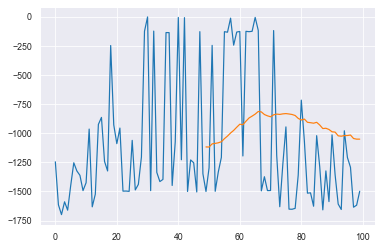

Step: 100
Step: 150


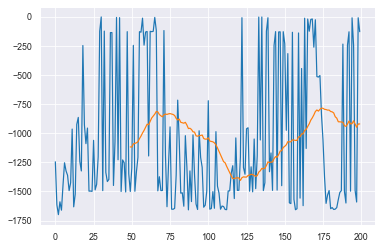

Step: 200
Step: 250


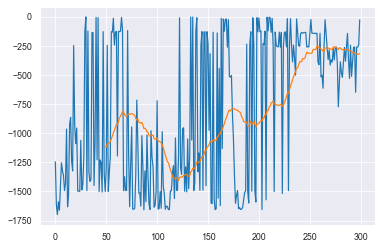

Exp: 1
Step: 0
Step: 50


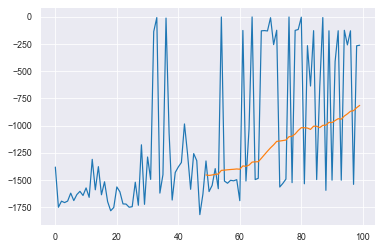

Step: 100
Step: 150


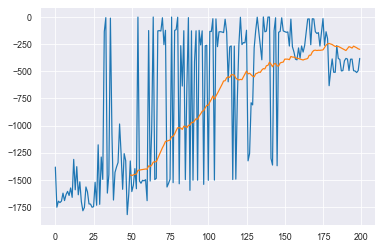

Step: 200
Step: 250


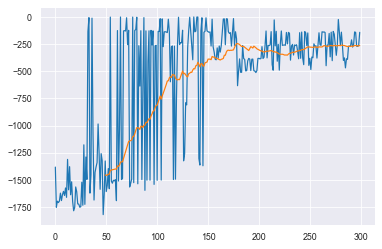

Exp: 2
Step: 0
Step: 50


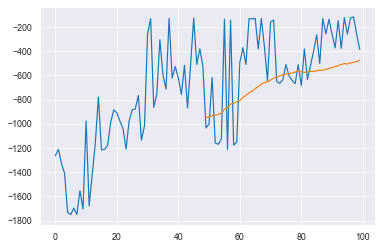

Step: 100
Step: 150


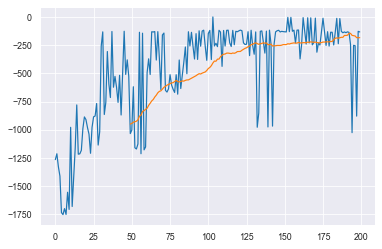

Step: 200
Step: 250


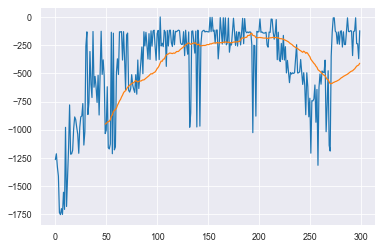

Exp: 3
Step: 0
Step: 50


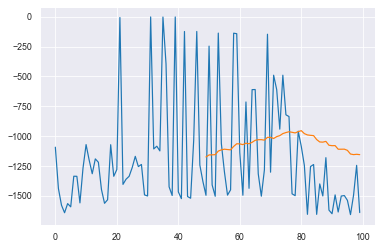

Step: 100
Step: 150


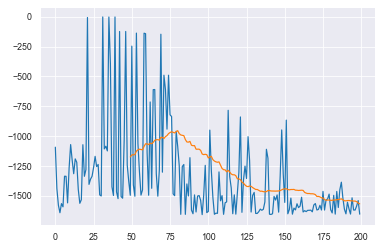

Step: 200
Step: 250


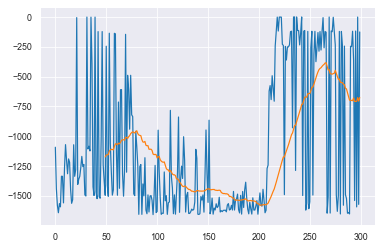

Exp: 4
Step: 0
Step: 50


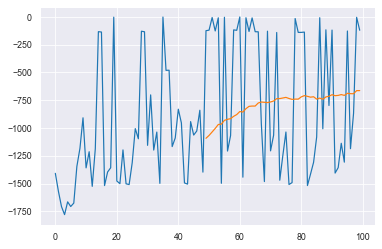

Step: 100
Step: 150


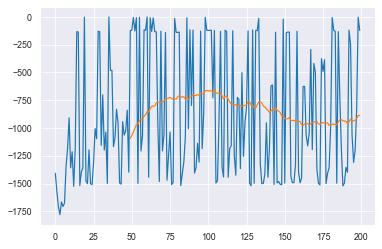

Step: 200
Step: 250


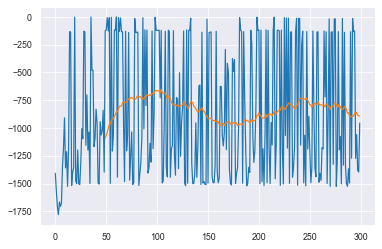

Exp: 5
Step: 0
Step: 50


In [ ]:
for epoch0 in range(10):
    print("Exp:",epoch0)
    agent=DDPG_SPER(agent_config)
    Iter=300
    G_log=[]
    for epoch in range(Iter):
        if epoch%50==0:print("Step:",epoch)
        done=False
        s=env.reset()
        G=0
        step=0
        while not done:
            a = agent.get_actions(s.reshape(1,-1))[0]
            sp, r, done, info = env.step(a)
            G+=r
            agent.memorize(s,a,r,sp,done,G)
            agent.learn()
            s = sp
            step+=1
        agent.summarize(step,G)
        G_log.append(G)
        if len(G_log)%100==0:
            plt.plot(G_log)
            plt.plot(pd.DataFrame(G_log).rolling(min(len(G_log),50)).mean())
            plt.show()
    G_LOG.append(G_log)

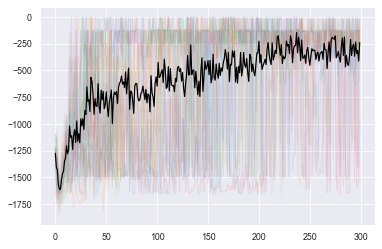

16

In [9]:
G=np.array(G_LOG).T
plt.plot(G,alpha=0.1)
plt.plot(G.mean(axis=1),color="black")
plt.show()
len(G_LOG)

In [10]:
import pickle
pickle.dump(G,open("results/G_DDPG_SPER_50_100-128-32.p","wb"))